# **Práctica 11: Regresión Ridge y Lasso**

In [49]:
# Cargamos las librerias necesarias
import numpy as np     # para calculos numericos
import pandas as pd    # para manejar dataframes
import seaborn as sns   # graficos mas atractivos
import matplotlib.pyplot as plt  # para visualizacion
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## Análisis exploratorio de datos

Vamos ase represenran los boxplots de las variables numéricas para detectar posibles valores atípicos (outliers). También se analiza la distribución de cada variable.

Esto es importante porque los valores extremos pueden afectar a los modelos de regresión, y conocer la distribución ayuda a entender si las relaciones pueden ser lineales ono.


In [45]:
# Cargamos y preparamos el dataset
company = pd.read_csv("C:company.csv")
print(company.head())
print(company.info())
print(company.duplicated().sum()) #duplicados

      TV  Radio  Newspaper  Sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3   12.0
3  151.5   41.3       58.5   16.5
4  180.8   10.8       58.4   17.9
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB
None
0


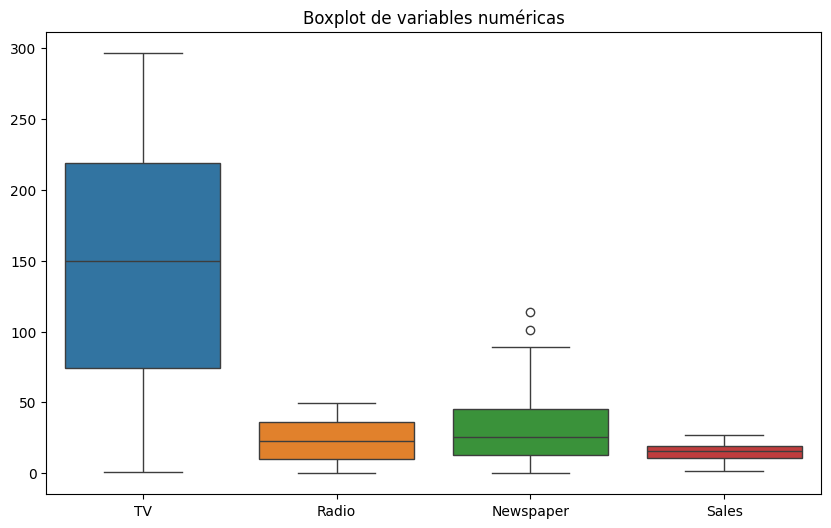

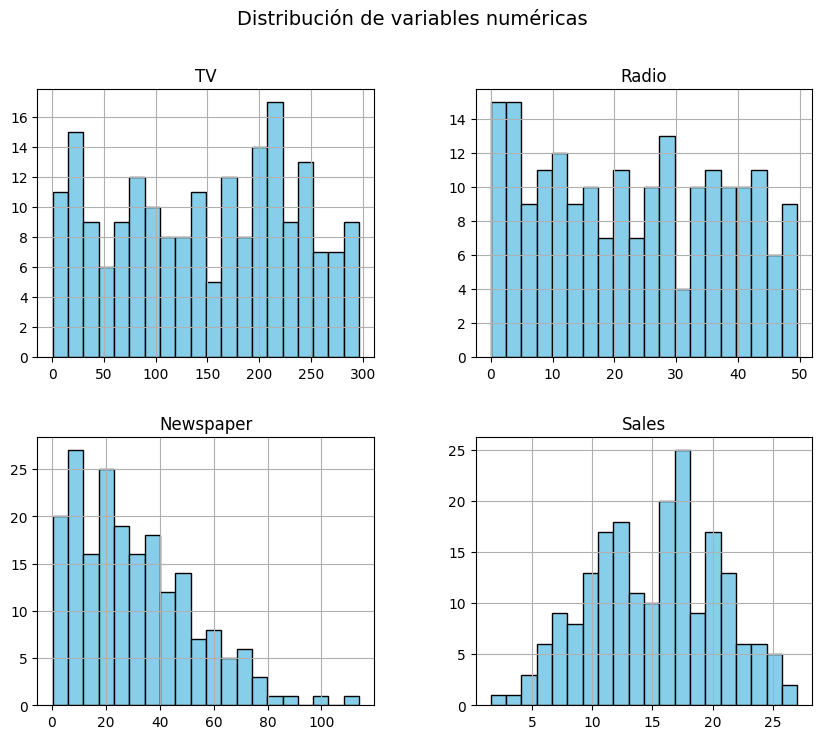

In [51]:
# Outliers
fig = plt.figure(figsize=(10, 6))
sns.boxplot(data=company)
plt.title("Boxplot de variables numéricas")
plt.show()

# Analisis de distribucion
company.hist(figsize=(10, 8), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Distribución de variables numéricas", fontsize=14)
plt.show()

Los datos parecen estar limpios, no hay nulos ni duplicados, todos tienen un formato manejable para el entrenamiento.

- La variable `Newspaper` presenta valores atípicos significativos.
- `TV` y `Radio` muestran una distribución más uniforme.
- `Sales` parece seguir una distribución normal, lo cual es favorable para aplicar modelos de regresión.

En cuanto al escalado de los datos, para aplicar Ridge y Lasso es obligatorio, ya que ambos penalizan los coeficientes y son sensibles a la escala de las variables.

In [4]:
X = company.drop('Sales', axis=1)
y = company['Sales']

## Escalado  y división de los datos


Se separan las variables independientes (TV, Radio, Newspaper) de la variable dependiente (Sales)Luegote se realiza un escalado de las variables con `StandardScaler` y se divide el dataset en entrenamiento y prueb.


In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# division de los datos con train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Búsqueda de hiperparametros (alpha) con validación cruzada para Lasso y Ridge

Se usa `GridSearchCV` para encontrar el mejor valor de alpha (parámetro de regularización) tanto para Ridge como Lasso. Se prueban 50 valores logarítmicamente espaciados entre 10⁻⁴ y 10⁴.


In [7]:
# Ridge
alphas = np.logspace(-4, 4, 50)
ridge_cv = GridSearchCV(Ridge(), param_grid={'alpha': alphas}, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)
best_ridge_alpha = ridge_cv.best_params_['alpha']


In [8]:
# Lasso
lasso_cv = GridSearchCV(Lasso(max_iter=10000), param_grid={'alpha': alphas}, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train, y_train)
best_lasso_alpha = lasso_cv.best_params_['alpha']


## Evaluación del conjunto de prueba


Se evalúalos dosos modelos usando el conjuntde pruebaba y se calculan las métricas de desempeño:
- Error Cuadrático Medio (MSE)
- Coeficiente de determinación (R²)

Esto nos permite comparar el ajuste real de cada modelo después de entrenarlos.


In [9]:
# evaluacion del conjunto de prueba
ridge_best = Ridge(alpha=best_ridge_alpha)
ridge_best.fit(X_train, y_train)
ridge_preds = ridge_best.predict(X_test)

lasso_best = Lasso(alpha=best_lasso_alpha, max_iter=10000)
lasso_best.fit(X_train, y_train)
lasso_preds = lasso_best.predict(X_test)

# Métricas
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} -> MSE: {mse:.4f}, R2: {r2:.4f}")

evaluate_model(y_test, ridge_preds, "Ridge")
evaluate_model(y_test, lasso_preds, "Lasso")


Ridge -> MSE: 2.9078, R2: 0.9059
Lasso -> MSE: 2.9077, R2: 0.9059


## Análisis de coeficientes

Se visualizan los coeficientes de cada modelo para observar cómo afecta la regularización:

- Ridge tiende a reducir los coeficientes, pero no los lleva a cero.
- Lasso puede llevar a cero los coeficientes de variables menos relevantes, actuando como un modelo de selección de características.


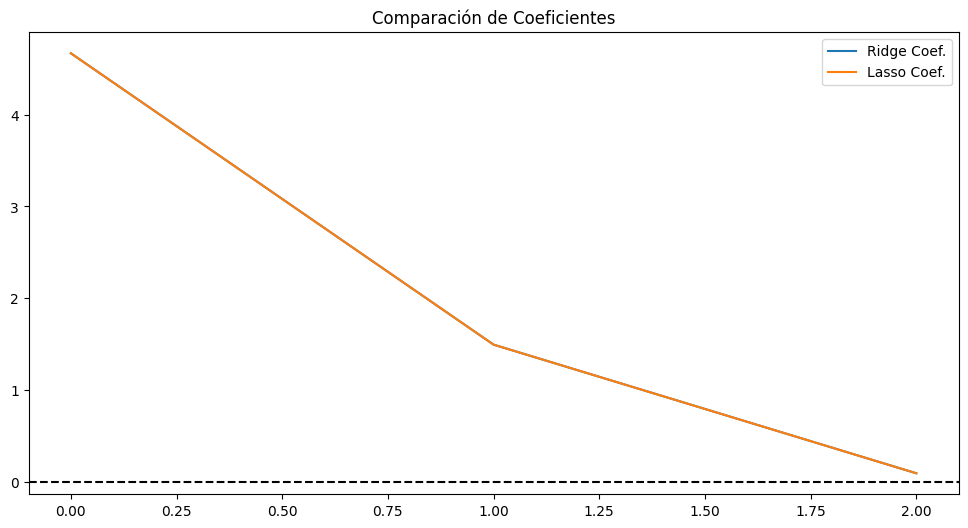

In [10]:
# Analisis de los coeficientes
plt.figure(figsize=(12, 6))
plt.plot(ridge_best.coef_, label="Ridge Coef.")
plt.plot(lasso_best.coef_, label="Lasso Coef.")
plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.title("Comparación de Coeficientes")
plt.show()


## Variación de coeficientes con alpha

Observamosva cómo cambian los coeficientes al variar el valor de alpha. A medida que alpha aumenta:
- En Ridge: los coeficientes disminuyen pero nunca llegan a cero.
- En Lasso: varios coeficientes se reducen a cero, eliminando variables.

Esto muestra la capacidad de Lasso para hacer selección automática de características.


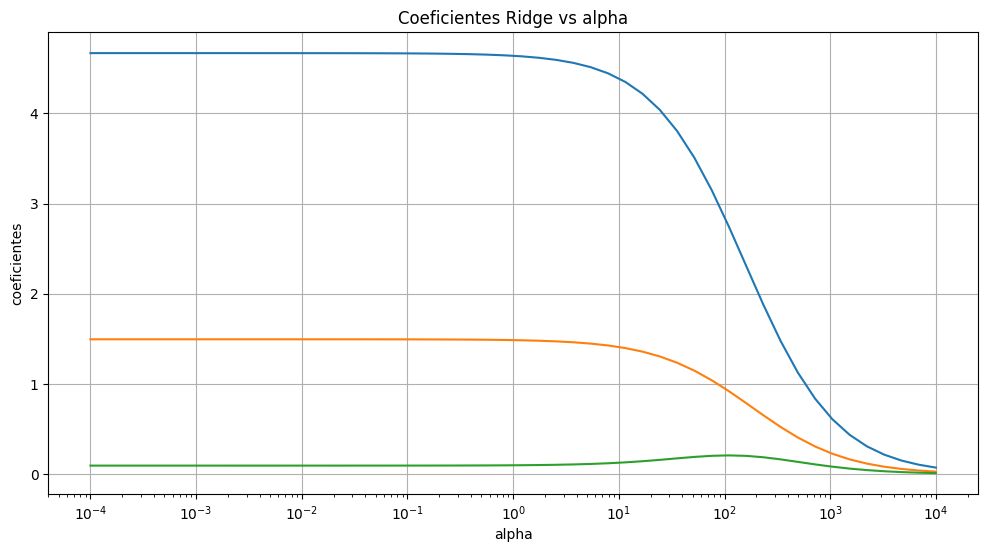

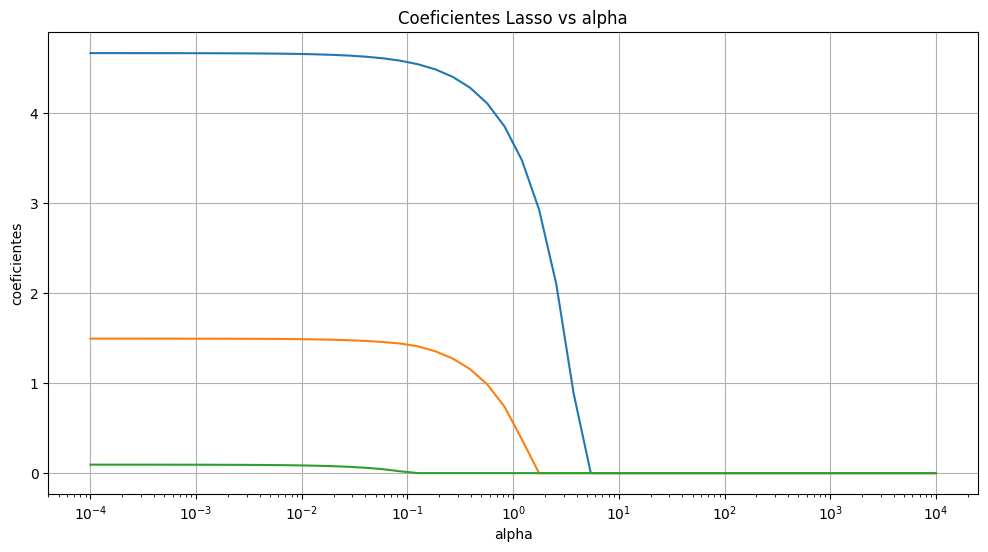

In [11]:
# Variación de coeficientes con alpha
coefs_ridge = []
coefs_lasso = []

for a in alphas:
    ridge = Ridge(alpha=a).fit(X_train, y_train)
    coefs_ridge.append(ridge.coef_)
    
    lasso = Lasso(alpha=a, max_iter=10000).fit(X_train, y_train)
    coefs_lasso.append(lasso.coef_)

# Plot Ridge
plt.figure(figsize=(12,6))
plt.plot(alphas, coefs_ridge)
plt.xscale('log')
plt.title("Coeficientes Ridge vs alpha")
plt.xlabel("alpha")
plt.ylabel("coeficientes")
plt.grid(True)
plt.show()

# Plot Lasso
plt.figure(figsize=(12,6))
plt.plot(alphas, coefs_lasso)
plt.xscale('log')
plt.title("Coeficientes Lasso vs alpha")
plt.xlabel("alpha")
plt.ylabel("coeficientes")
plt.grid(True)
plt.show()


## Conclusión Final: Regresión Ridge y Lasso

### ¿Cuál de los dos métodos tiene mejor rendimiento en este dataset?

Los dos modelos muestran un rendimiento parecido en cuanto a MSE y R². Aunque, en este caso, el modelo **Ridge** ha obtenido un **ligeramente mejor R² y menor MSE**, lo que sugiere un mejor ajuste general. Esto es esperable en datasets donde todas las variables tienen cierta relevancia o donde existe multicolinealidad, como parece ser el caso.


### ¿Cómo afecta la regularización al modelo?

La regularización introduce una penalización sobre los coeficientes para evitar que tomen valores extremos, lo cual ayuda a prevenir el sobreajuste.

- En **Ridge**, los coeficientes se reducen en magnitud, pero **ninguno se elimina completamente**. Esto lo hace adecuado cuando **todas las variables aportan algo de información**.
- En **Lasso**, algunos coeficientes se **reducen a cero**, lo que significa que **elimina variables irrelevantes**. Esto es útil como técnica de selección de características.


### ¿Qué ventajas ofrece la regularización en problemas con multicolinealidad o sobreajuste?

- **Multicolinealidad**: tanto Ridge como Lasso son útiles, pero **Ridge** suele ser más efectivo porque distribuye la penalización entre variables correlacionadas.
- **Sobreajuste**: ambos modelos reducen el riesgo de sobreajuste al limitar la complejidad del modelo.


### ¿En qué situaciones es más conveniente usar Ridge o Lasso?

- Mejor usar **Ridge** cuando:
  - Hay **multicolinealidad** entre las variables.
  - Todas las variables se espera que tengan algún impacto.
  - El objetivo es mejorar la generalización sin eliminar variables.

- Mejor usar **Lasso** cuando:
  - Se sospecha que hay **variables irrelevantes**.
  - Se desea realizar **selección automática de características**.
  - Se quiere un modelo más **sencillo e interpretable**.


### ¿Cómo varían los coeficientes cuando cambia el valor de alpha?

- A medida que aumenta `alpha`, los coeficientes de **Ridge** disminuyen progresivamente, pero permanecen distintos de cero.
- En **Lasso**, a partir de cierto valor de `alpha`, varios coeficientes **se convierten en cero**, lo que reduce la complejidad del modelo.

Este comportamiento se puede observar claramente en los gráficos generados, donde los coeficientes de Lasso caen bruscamente a cero, mientras que en Ridge lo hacen suavemente.